# Check observing window calculation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.coordinates import AltAz, Angle, EarthLocation, get_sun, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
import seaborn as sns
import sqlite3

import constraints as c
from db import DBConnectorSQLite, SQLiteConnection
from fieldgrid import FieldGrid, FieldGridIsoLat
from surveyplanner import Field, ObsWindow, Telescope, SurveyPlanner, Prioritizer

Create telescope:

In [3]:
db = DBConnectorSQLite('test_planner_temp.sqlite3')

In [4]:
telescope = db.get_observatory('Skinakas')
telescope = Telescope(
        telescope['lat'], telescope['lon'], telescope['height'], telescope['utc_offset'], name=telescope['name'])
print(telescope)

Telescope Skinakas created.
Telescope 
Name: Skinakas
Lat:     +35.2119 deg
Lon:      24.8992 deg
Height:   1750.00 m
UTC offset:  2.00 hours



Read constraints from database:

In [5]:
constraints = db.get_constraints('Skinakas')
print(constraints)

{'Twilight': {'twilight': -12.0}, 'AirmassLimit': {'limit': 2.0, 'conversion': 'secz'}, 'HourangleLimit': {'limit': 5.33, 'limit_lo': -5.33}, 'MoonDistance': {'limit': 10.0}}


Read the twilight definition (i.e. Sun declination at which the night 'starts') from the `constraints`-dictionary:

In [6]:
twilight = constraints['Twilight']['twilight']
print(twilight)

-12.0


Remove the `'Twilight'` entry from the dictionary. All remaining entries are telescope specific observational constraints:

In [7]:
del constraints['Twilight']

(1) Parse the constraints names, parameter names, and parameter values into executable code, (2) create the corresponding constraint class instances, and (3) add them to the `telescope`-instance:

In [8]:
for constraint_name, params in constraints.items():
    
    # parse constraint code:
    text = f"c.{constraint_name}("
    
    for arg, val in params.items():
        if isinstance(val, str):
            text += f"{arg}='{val}', "
        else:
            text += f"{arg}={val}, "
    
    if text[-1] == "(":
        text += ")"
    else:
        text = f"{text[:-2]})"
    
    print(text)
    
    # evaluate code and add constraint to telescope:
    constraint = eval(text)
    telescope.add_constraint(constraint)

c.AirmassLimit(limit=2.0, conversion='secz')
Constraint added: Airmass limit: 2.00
c.HourangleLimit(limit=5.33, limit_lo=-5.33)
Constraint added: Hourangle limit:
Lower limit: -5.33 hourangle
Upper limit: 5.33 hourangle
c.MoonDistance(limit=10.0)
Constraint added: Moon distance: 10.00 deg


Create `SurveyPlanner` instance. The database is irrelevant, we just need one method of the class:

In [9]:
surveyplanner = SurveyPlanner('test_planner_temp.sqlite3')

Get a field:

In [200]:
field_id = 359 # rising field in Jan 2024
#field_id = 478 # setting field in Jan 2024
field = db.get_field_by_id(field_id)[0]
field = surveyplanner._tuple_to_field(field)

Run calculation for one month with fine time grid for reference:

In [201]:
# config test:
time_intervals = [(60, 1), (600, 60), (600, 0)] # (init, refined) in sec
#time_intervals = [(60, 5)] # (init, refined) in sec

year = 2024
month = 1

#------------------------------
tags = []
day = []
time_sunset = []
time_sunrise = []
obswindow_start = []
obswindow_stop = []
obswindow_duration = []
obswindow_duration_diff = []

for time_interval_init, time_interval_refine in time_intervals:
    tag = f'{time_interval_init}-{time_interval_refine}'
    time_interval_init = TimeDelta(time_interval_init * u.s)
    time_interval_refine = TimeDelta(time_interval_refine * u.s)
    
    for d in range(1, 32):
        print(f'\rTest interval {tag}: Day {d} of 31..', end='')
        t_sunset, t_sunrise = telescope.get_sun_set_rise(year, month, d, twilight)
        tags.append(tag)
        day.append(d)
        time_sunset.append(np.mod(t_sunset.mjd, 1))
        time_sunrise.append(np.mod(t_sunrise.mjd, 1))

        frame = telescope.get_frame(t_sunset, t_sunrise, time_interval_init, round_up=round_up)

        obsw_start, obsw_stop = field.get_obs_window(telescope, frame, t_sunrise, refine=time_interval_refine)[0]
        obswindow_start.append(np.mod(obsw_start.mjd, 1))
        obswindow_stop.append(np.mod(obsw_stop.mjd, 1))
        obswindow_duration.append(obsw_stop.mjd - obsw_start.mjd)
        
        if d == 1:
            obswindow_duration_diff.append(np.nan)
        else:
            obswindow_duration_diff.append(obswindow_duration[-1] - obswindow_duration[-2])
    
    print(f'\rTest interval {tag}: Done.         ')

# simple "modulus" hack to align obswindow start time over two days, i.e. remove a large jump later in the plots:
obswindow_start = np.array(obswindow_start)
obswindow_start = np.where(obswindow_start<0.5, obswindow_start+1, obswindow_start)

data = DataFrame({
        'intervals': tags, 'day': day, 'time_sunset': time_sunset, 'time_sunrise': time_sunrise, 'obswindow_start': obswindow_start,
        'obswindow_stop': obswindow_stop, 'obswindow_duration': obswindow_duration, 'obswindow_duration_diff': obswindow_duration_diff})
data['obswindow_duration_diff (s)'] = data['obswindow_duration_diff'] * 24 * 3600
data['obswindow_duration_diff_shifted (s)'] = data['obswindow_duration_diff (s)'] - np.nanmedian(data['obswindow_duration_diff (s)'])

Test interval 60-1: Done.         
Test interval 600-60: Done.         
Test interval 600-0: Done.         


In [202]:
data

,intervals,day,time_sunset,time_sunrise,obswindow_start,obswindow_stop,obswindow_duration,obswindow_duration_diff,obswindow_duration_diff (s),obswindow_duration_diff_shifted (s)
0,60-1,1,0.679499,0.186976,1.020718,0.186976,0.166258,NaN,NaN,NaN
1,60-1,2,0.679994,0.187121,1.017986,0.187121,0.169135,0.002877,248.558304,28.910747
2,60-1,3,0.680501,0.187248,1.015266,0.187248,0.171982,0.002846,245.926651,26.279094
3,60-1,4,0.681019,0.187355,1.012535,0.187355,0.174820,0.002839,245.277208,25.629651
4,60-1,5,0.681548,0.187443,1.009803,0.187443,0.177640,0.002820,243.610756,23.963198
...,...,...,...,...,...,...,...,...,...,...
88,600-0,27,0.694811,0.184263,0.951389,0.184263,0.232874,0.006587,569.118695,349.471138
89,600-0,28,0.695450,0.183886,0.951389,0.183886,0.232498,-0.000377,-32.559831,-252.207389
90,600-0,29,0.696090,0.183490,0.944444,0.183490,0.239046,0.006548,565.777293,346.129736
91,600-0,30,0.696729,0.183076,0.944444,0.183076,0.238632,-0.000414,-35.795903,-255.443461


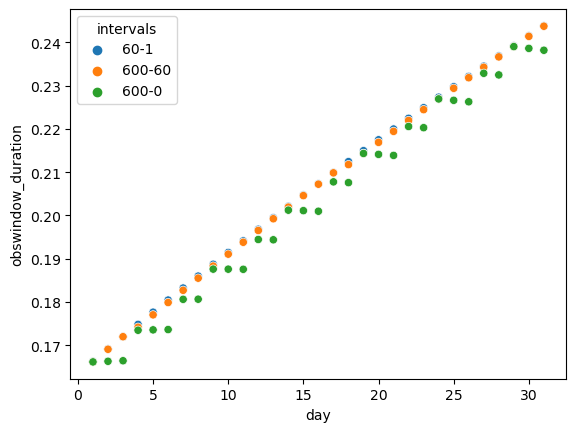

In [203]:
sns.scatterplot(data=data, x='day', y='obswindow_duration', hue='intervals');

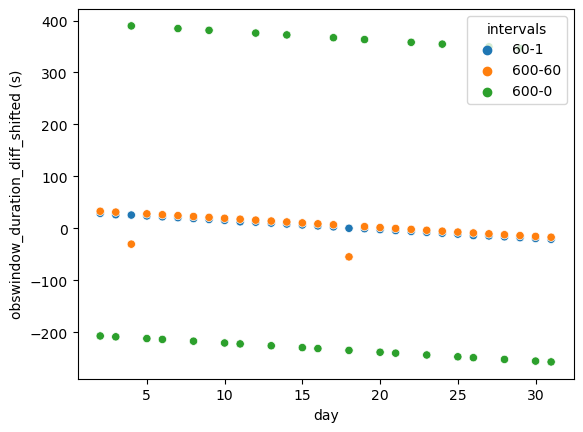

In [204]:
sns.scatterplot(data=data, x='day', y='obswindow_duration_diff_shifted (s)', hue='intervals');

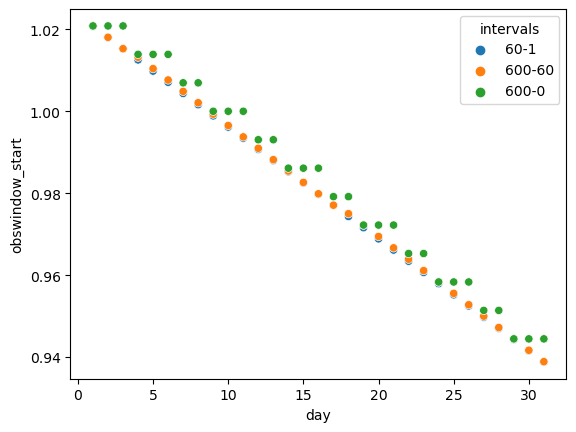

In [205]:
sns.scatterplot(data=data, x='day', y='obswindow_start', hue='intervals');

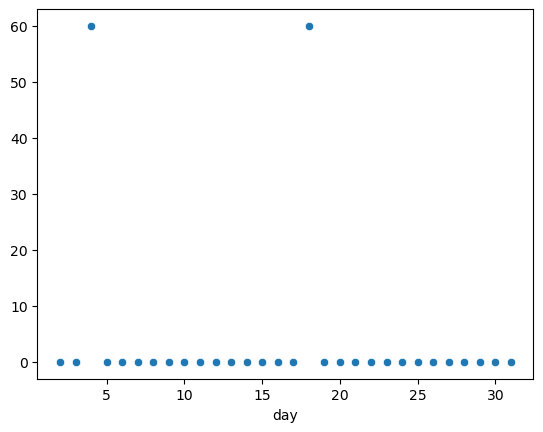

In [206]:
tag = '600-60'
x = data.loc[data['intervals']==tag, 'day']
y = np.r_[np.nan, np.diff(data.loc[data['intervals']==tag, 'obswindow_start'])] * 24 * 3600
y -= np.nanmedian(y)
sns.scatterplot(x=x, y=y);

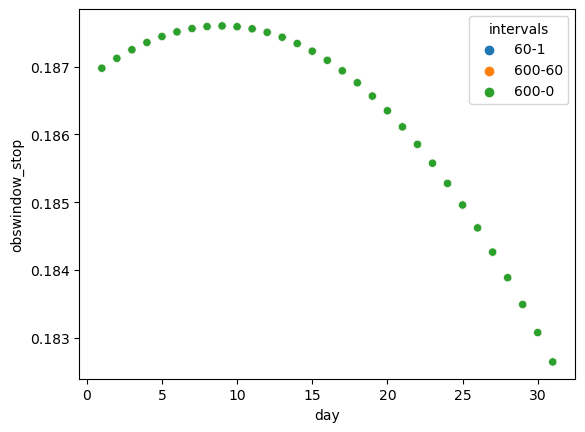

In [207]:
sns.scatterplot(data=data, x='day', y='obswindow_stop', hue='intervals');

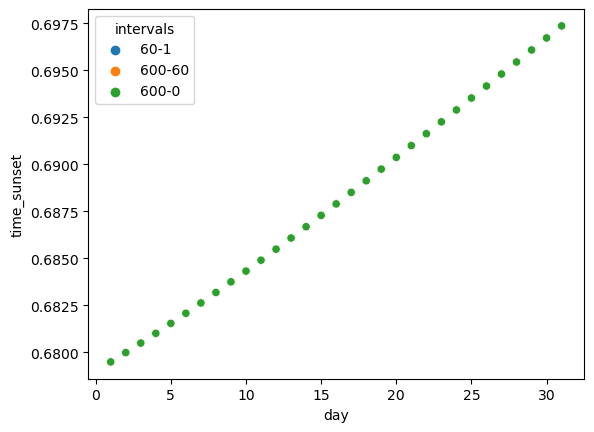

In [208]:
sns.scatterplot(data=data, x='day', y='time_sunset', hue='intervals');

For setting sources the start time equals the Sun set time:

In [209]:
np.all(data['obswindow_start'] == data['time_sunset'])

False

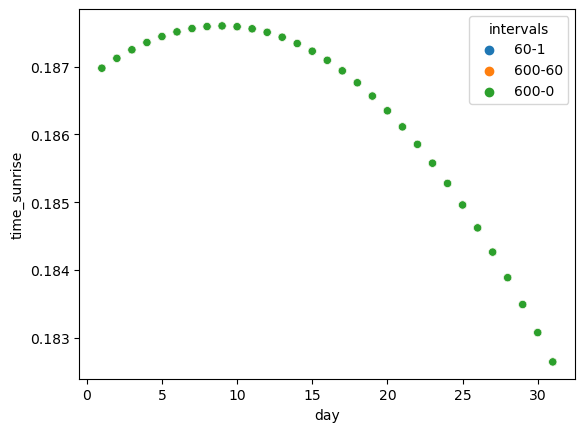

In [210]:
sns.scatterplot(data=data, x='day', y='time_sunrise', hue='intervals');

For rising sources the stop time is limited by the Sun rise time. Therefore, the two must be equal (to within computer accuracy):

In [212]:
np.all(np.isclose(data['time_sunrise'], data['obswindow_stop']))

True

**Results:**

- Without refinement the observing window durations can jump from one day to the next. The reason is the coarse time sampling.
- With refinement we can reduce these jumps.
- It is important to find a good compromise between accuracy and calculation time. The latter increases with a fine refinement time grid. I am testing this systematically in a section in `Develop_ObservabilityStatusUpdate.ipynb`.